<a href="https://colab.research.google.com/github/Monisha2604/Javascript/blob/master/DT_spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!tar xf spark-3.0.2-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()

In [ ]:

from pyspark.sql import SparkSession
spark= SparkSession.builder.appName('Customers').getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/Copy of Final_project_processed_data.csv")
data=spark.read.csv("/content/drive/MyDrive/Copy of Final_project_processed_data.csv",inferSchema=True,header=True)
data.show()

+---+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+
|_c0|          psfMag_u|          psfMag_g|          psfMag_r|          psfMag_i|          psfMag_z|           dered_u|           dered_g|           dered_r|           dered_i|           dered_z|        fiberMag_u|        fiberMag_g|        fiberMag_r|        fiberMag_i|        fiberMag_z|        petroR50_r|        petroR50_z|        petroR90_r|        petroR90_z|                 r|                 i|                 z|           redshift|
+---+------------------+------------------+------------------+------------------+------------------+------------

In [ ]:
from sklearn.tree import DecisionTreeRegressor 
  
# create a regressor object
regressor = DecisionTreeRegressor(random_state = 0) 
  

In [ ]:
x=df.iloc[:,:-1].values
y=df.iloc[:,-1].values
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=42)

In [ ]:
import timeit
start_time = timeit.default_timer()
regressor.fit(x_train, y_train)
end_time = timeit.default_timer()

execution_time = end_time - start_time
print(f'run-time: {round(execution_time/60.0, 2)}')

run-time: 3.32


In [ ]:
y_pred = regressor.predict(x_test)

In [ ]:
from sklearn import metrics
print(metrics.r2_score(y_test,y_pred))

0.4370830959478943


In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler


In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor

In [ ]:
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])

In [ ]:
transformed= transData(data)
transformed.show(3)

+--------------------+------------------+
|            features|             label|
+--------------------+------------------+
|[0.0,24.35021,22....|0.8162744000000001|
|[1.0,24.47392,22....|         0.5564747|
|[2.0,23.38084,22....|          0.619608|
+--------------------+------------------+
only showing top 3 rows



In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorIndexer

featureIndexer = VectorIndexer(inputCol="features", \
                               outputCol="indexedFeatures").fit(transformed)

data = featureIndexer.transform(transformed)
data.show(5,True)


+--------------------+------------------+--------------------+
|            features|             label|     indexedFeatures|
+--------------------+------------------+--------------------+
|[0.0,24.35021,22....|0.8162744000000001|[0.0,24.35021,22....|
|[1.0,24.47392,22....|         0.5564747|[1.0,24.47392,22....|
|[2.0,23.38084,22....|          0.619608|[2.0,23.38084,22....|
|[3.0,24.722579999...|         0.4611808|[3.0,24.722579999...|
|[4.0,25.2249,24.4...|         0.6421724|[4.0,25.2249,24.4...|
+--------------------+------------------+--------------------+
only showing top 5 rows



In [ ]:
(trainingData, testData) = data.randomSplit([0.8, 0.2])

In [ ]:
dt = DecisionTreeRegressor(featuresCol="indexedFeatures",maxDepth=30)

# Chain indexer and tree in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, dt])


In [ ]:
import time
start_time = time.process_time()
model = pipeline.fit(trainingData)
end_time = time.process_time()

delta_time = end_time - start_time
print(f'run-time: {round(delta_time/60.0, 2)}')


In [ ]:
import timeit

start=timeit.default_timer()

model = pipeline.fit(trainingData)

stop=timeit.default_timer()
execution_time = (stop - start)/60
print("Program Executed in minutes "+str(execution_time))

In [ ]:
pred = model.transform(testData)

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(pred)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.455845


In [ ]:
pred.select("prediction", "label", "features").show(5) 


+-------------------+----------+--------------------+
|         prediction|     label|            features|
+-------------------+----------+--------------------+
|0.07392323021037464|0.06366909|[18.0,22.00384,20...|
| 0.3263506552191518| 0.3502668|[32.0,25.17381,21...|
| 0.6253202917928479| 0.4401068|[38.0,24.36361,23...|
|  0.567333247054659|  0.440762|[40.0,23.32368,22...|
| 0.1184790423517536| 0.1281856|[47.0,21.37297000...|
+-------------------+----------+--------------------+
only showing top 5 rows



In [ ]:
type(pred)

pyspark.sql.dataframe.DataFrame

In [ ]:
#result=pred.predictions.collect()

In [ ]:
#dataframe=spark.createDataFrame(result)

In [ ]:
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="r2")
rmse = evaluator.evaluate(pred)
print("R2 on test data = %g" % rmse)

R2 on test data = 0.602507


In [ ]:
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(pred)
print("MAE on test data = %.3f" %  mae)

MAE on test data = 0.212


In [ ]:
import numpy as np
y_test=np.array(pred.select("label").collect())
y_pred=np.array(pred.select("prediction").collect())
import matplotlib.pyplot as plt

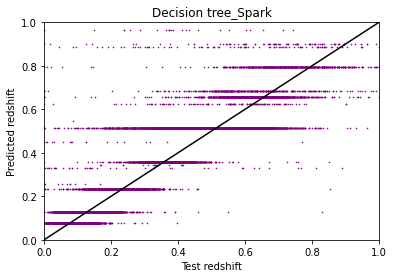

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.title("Decision tree_Spark")
plt.scatter(y_test[:30000], y_pred[:30000], s=0.34, color="purple")
ax1.set_xlabel("Test redshift")
ax1.set_ylabel("Predicted redshift")
ax1.plot([0,4], [0,4], '-r',color="black")
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

    
plt.show()